In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [12]:
vb = pd.read_csv("../data/vb_data_3_numZone.csv")
q_values_raw = pickle.load(open('../output/q_values_new.pkl', 'rb'))
q_values = np.asarray([q_values_raw[i,0] for i in range(len(q_values_raw))])
# clipping
q_values[q_values>1] = 1
q_values[q_values<-1] = -1
y_prob_tree = pickle.load(open('../output/y_probabilities_tree.pkl', 'rb'))
q_tree = y_prob_tree[:,1]*2 - 1
#y_prob_forest = pickle.load(open('../output/y_probabilities_forest.pkl', 'rb'))
#q_forest = y_prob_forest[:,1]*2 - 1

#q_diff = q_values-q_tree
q_diff = q_forest-q_tree

In [4]:
X = vb.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)

print(len(X.columns), 'columns in numerical dataframe')

cols = [col for col in list(X.columns) if X[col].dtype == 'object']
X = pd.get_dummies(data=X, columns=cols)

print(len(X.columns), 'columns in numerical dataframe after dummies')

93 columns in numerical dataframe
204 columns in numerical dataframe after dummies


In [10]:
# set up regressor tree for difference
for i in range(10,17,2):
    print('Checking max_depth =', i)
    clf = DecisionTreeRegressor(max_depth=i)
    # Perform 5-fold cross validation
    scores = cross_val_score(estimator=clf, X=X, y=q_diff, cv=5, n_jobs=4, scoring='r2')
    print('Mean cross validation accuracy:', scores.mean())

Checking max_depth = 1
Mean cross validation accuracy: 0.005676481401442657
Checking max_depth = 3
Mean cross validation accuracy: 0.051202060486038016
Checking max_depth = 5
Mean cross validation accuracy: 0.1778330334352714
Checking max_depth = 7
Mean cross validation accuracy: 0.3700660277752367
Checking max_depth = 9
Mean cross validation accuracy: 0.5236373161335
Checking max_depth = 11
Mean cross validation accuracy: 0.5693157703819445


In [17]:
for i in range(20,100,30):
    print('Checking min_samples_split =', i)
    clf = DecisionTreeRegressor(min_samples_split=i)
    # Perform 5-fold cross validation
    scores = cross_val_score(estimator=clf, X=X, y=q_diff, cv=5, n_jobs=4, scoring='r2')
    print('Mean cross validation accuracy:', scores.mean())

Checking min_samples_split = 20
Mean cross validation accuracy: 0.399750021555959
Checking min_samples_split = 50
Mean cross validation accuracy: 0.4291747998332066
Checking min_samples_split = 80
Mean cross validation accuracy: 0.4229114114729858


In [18]:
clf = DecisionTreeRegressor(min_samples_split=50)
clf.fit(X, q_diff)
q_diff_pred = clf.predict(X)
print(metrics.r2_score(q_diff, q_diff_pred))

0.6695408862551632


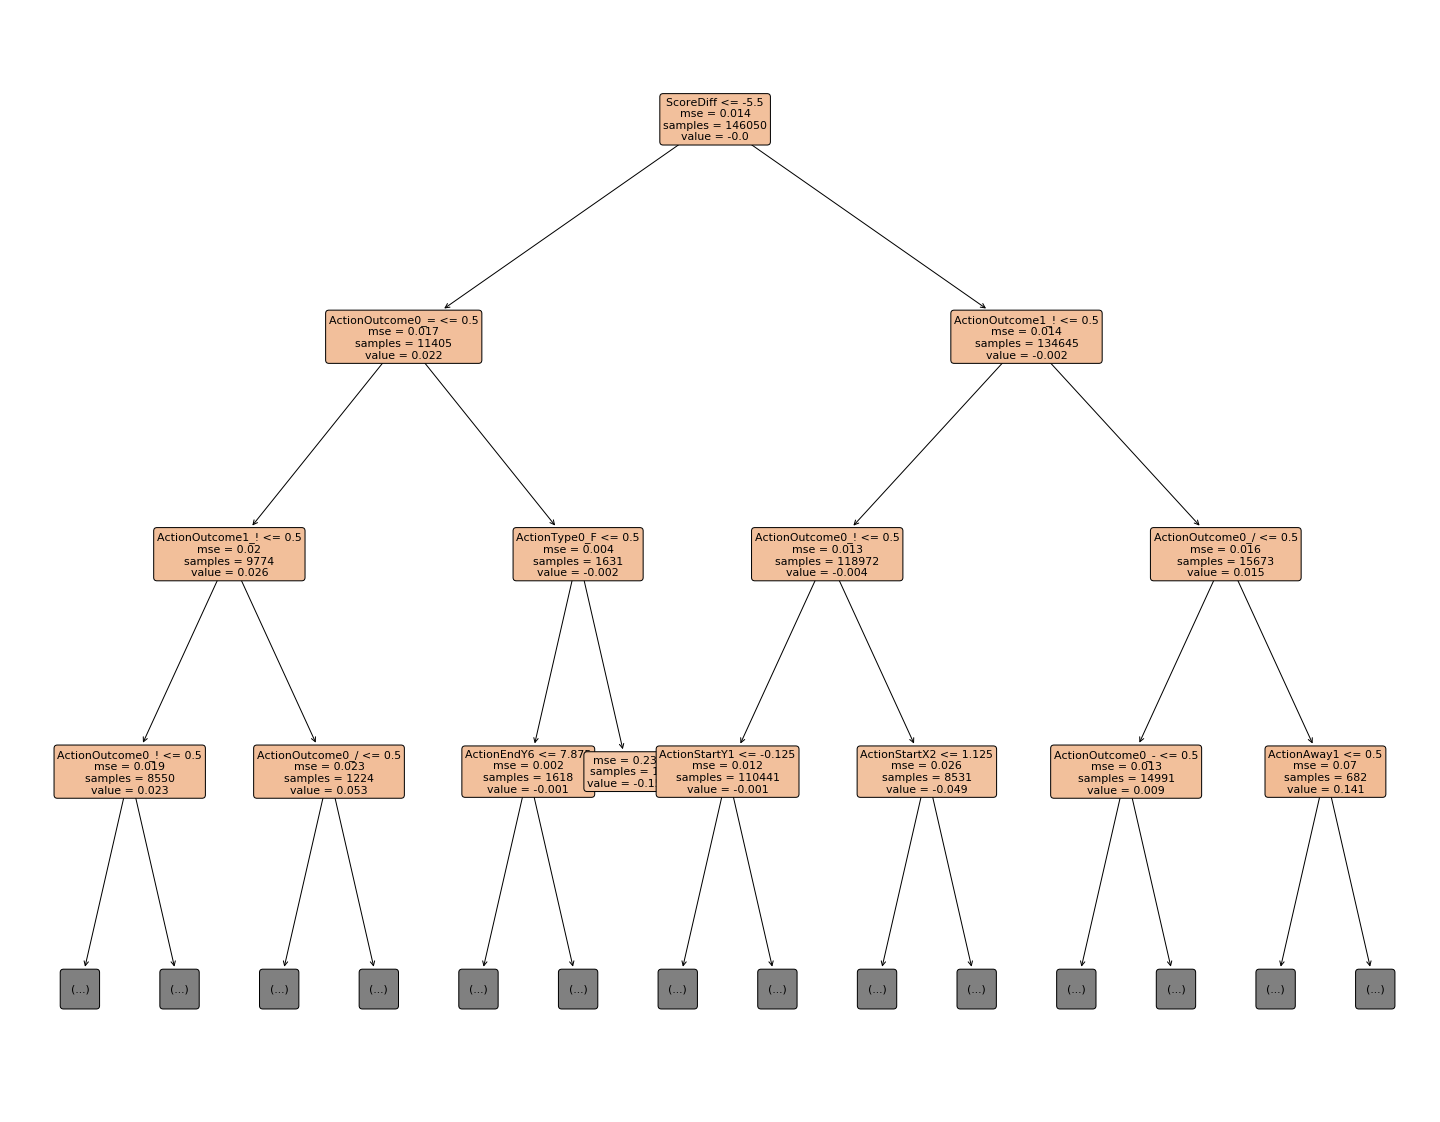

In [20]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25,20))
a = plot_tree(clf, feature_names=X.columns, filled=True, rounded=True, fontsize=11, max_depth=3)
plt.show()

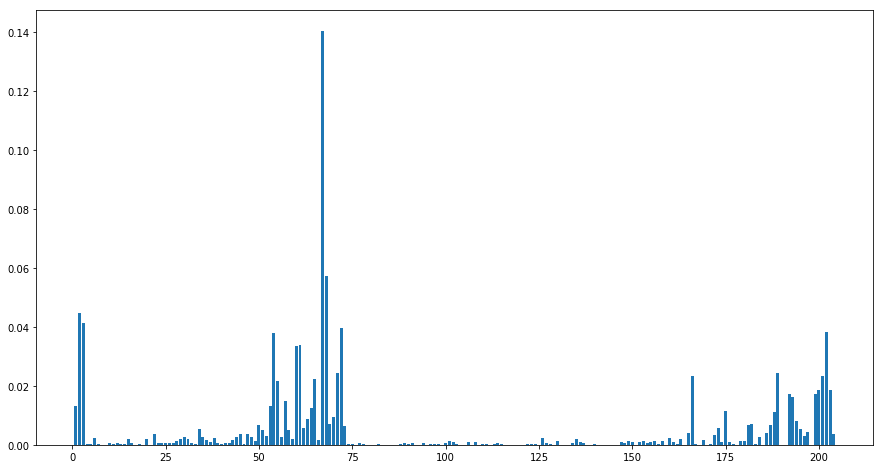

1 ActionHome0 0.141
2 ActionAway0 0.057
3 ScoreMax 0.045
4 ScoreDiff 0.041
5 ActionEndY0 0.040
6 ActionOutcome0_- 0.038
7 ActionAway2 0.038
8 ActionAway1 0.034
9 ActionHome1 0.034
10 ActionEndX0 0.024
11 ActionOutcome1_- 0.024
12 ActionType2_A 0.024
13 ActionOutcome0_+ 0.023
14 ActionEndY1 0.022
15 ActionStartX2 0.022
16 ActionOutcome0_# 0.019
17 ActionOutcome0_/ 0.019
18 ActionOutcome0_! 0.017
19 ActionType0_A 0.017
20 ActionType0_B 0.016
21 ActionEndX2 0.015
22 ActionHome2 0.013
23 SetNumber 0.013
24 ActionEndX1 0.012
25 ActionOutcome2_+ 0.012


In [21]:
plt.figure(figsize=(15,8))
plt.bar(range(1,205),clf.feature_importances_)
plt.show()

indxs = clf.feature_importances_.argsort()[-25:][::-1]
for i in range(1,len(indxs)+1):
    idx = indxs[i-1]
    print('%d %s %.3f' % (i, X.columns[idx], clf.feature_importances_[idx]))

In [22]:
mean_overall = np.mean(q_diff)
print('Mean overall: %.6f' % (mean_overall))
for action in ['S','R','E','A','B','D']:
    for outcome in ['=','-','/','!','+','#']:
        cond = (vb.ActionOutcome0 == outcome) & (vb.ActionType0 == action)
        if sum(cond)>20:
            print('Mean diff with condition %s%s: %.4f (NN=%.4f, forest=%.4f)' % \
                  (action, outcome, np.abs(mean_overall-np.mean(q_diff[cond])),\
                     np.mean(np.abs(q_values[cond])), np.mean(np.abs(q_forest[cond])) ))

Mean overall: -0.000016
Mean diff with condition S=: 0.0000 (NN=0.9975, forest=1.0000)
Mean diff with condition S-: 0.0003 (NN=0.3241, forest=0.3264)
Mean diff with condition S!: 0.1018 (NN=0.1081, forest=0.1089)
Mean diff with condition S+: 0.0718 (NN=0.1893, forest=0.2060)
Mean diff with condition S#: 0.0000 (NN=0.9949, forest=0.9996)
Mean diff with condition R=: 0.0000 (NN=0.9969, forest=1.0000)
Mean diff with condition R-: 0.0001 (NN=0.1929, forest=0.2083)
Mean diff with condition R!: 0.0440 (NN=0.1050, forest=0.1112)
Mean diff with condition R+: 0.0180 (NN=0.2840, forest=0.2910)
Mean diff with condition R#: 0.0009 (NN=0.3966, forest=0.4034)
Mean diff with condition E=: 0.0150 (NN=0.9906, forest=0.9913)
Mean diff with condition E-: 0.0199 (NN=0.2397, forest=0.2281)
Mean diff with condition E+: 0.0025 (NN=0.3166, forest=0.3310)
Mean diff with condition E#: 0.0011 (NN=0.2912, forest=0.3655)
Mean diff with condition A=: 0.0016 (NN=0.9934, forest=0.9936)
Mean diff with condition A-: 0.

In [26]:
cond = (vb.ActionOutcome0 == '!') & (vb.ActionType0 == 'S') & (vb.ActionHome0 == 1)
print('Home S!')
print('Q by NN =', np.mean(q_values[cond]))
print('Q by tree =', np.mean(q_tree[cond]))
print('Difference =', np.mean(q_diff[cond]))
print(sum(cond), 'occurences')
print('')
cond = (vb.ActionOutcome1 == '!') & (vb.ActionType1 == 'S') & (vb.ActionHome1 == 1)
print('Home S! (1 action later)')
print('Q by NN =', np.mean(q_values[cond]))
print('Q by tree =', np.mean(q_tree[cond]))
print('Difference =', np.mean(q_diff[cond]))
print(sum(cond), 'occurences')
print('')
cond = (vb.ActionOutcome0 == '+') & (vb.ActionType0 == 'S') & (vb.ActionHome0 == 1)
print('Home S+')
print('Q by NN =', np.mean(q_values[cond]))
print('Q by tree =', np.mean(q_tree[cond]))
print('Difference =', np.mean(q_diff[cond]))
print(sum(cond), 'occurences')
print('')
cond = (vb.ActionOutcome1 == '+') & (vb.ActionType1 == 'S') & (vb.ActionHome1 == 1)
print('Home S+ (1 action later)')
print('Q by NN =', np.mean(q_values[cond]))
print('Q by tree =', np.mean(q_tree[cond]))
print('Difference =', np.mean(q_diff[cond]))
print(sum(cond), 'occurences')
print('')
cond = (vb.ActionOutcome0 == '!') & (vb.ActionType0 == 'S') & (vb.ActionAway0 == 1)
print('Away S!')
print('Q by NN =', np.mean(q_values[cond]))
print('Q by tree =', np.mean(q_tree[cond]))
print('Difference =', np.mean(q_diff[cond]))
print(sum(cond), 'occurences')
print('')
cond = (vb.ActionOutcome0 == '+') & (vb.ActionType0 == 'S') & (vb.ActionAway0 == 1)
print('Away S+')
print('Q by NN =', np.mean(q_values[cond]))
print('Q by tree =', np.mean(q_tree[cond]))
print('Difference =', np.mean(q_diff[cond]))
print(sum(cond), 'occurences')

Home S!
Q by NN = -0.11581368
Q by tree = 0.10344054690126647
Difference = -0.21925421762011127
2064 occurences

Home S! (1)
Q by NN = -0.117424265
Q by tree = -0.18501783590963145
Difference = 0.06759356961567424
2064 occurences

Home S+
Q by NN = 0.20700519
Q by tree = 0.10344054690126646
Difference = 0.10356463490394127
3084 occurences

Home S+ (1)
Q by NN = 0.20632589
Q by tree = 0.23876945264605082
Difference = -0.032443575562655404
3084 occurences

Away S!
Q by NN = 0.099528946
Q by tree = 0.10679611650485432
Difference = -0.0072671740070315285
1904 occurences

Away S+
Q by NN = -0.16997345
Q by tree = -0.1658620591764368
Difference = -0.00411138765998243
2822 occurences


In [28]:
for diff in range(-15,16):
    cond = (vb.ScoreDiff == diff) & (vb.ActionHome0 == 1)
    print('Home action, score difference %d, Q difference %.3f (%d samples)' % (diff, np.mean(q_diff[cond]), sum(cond)))
print()
for diff in range(-15,16):
    cond = (vb.ScoreDiff == diff) & (vb.ActionAway0 == 1)
    print('Away action, score difference %d, Q difference %.3f (%d samples)' % (diff, np.mean(q_diff[cond]), sum(cond)))
    #print(sum(cond), 'occurences')

Home action, score difference -15, Q difference 0.029 (17 samples)
Home action, score difference -14, Q difference -0.005 (27 samples)
Home action, score difference -13, Q difference 0.017 (66 samples)
Home action, score difference -12, Q difference 0.034 (104 samples)
Home action, score difference -11, Q difference 0.030 (194 samples)
Home action, score difference -10, Q difference 0.019 (336 samples)
Home action, score difference -9, Q difference 0.021 (575 samples)
Home action, score difference -8, Q difference 0.028 (968 samples)
Home action, score difference -7, Q difference 0.021 (1398 samples)
Home action, score difference -6, Q difference 0.018 (1980 samples)
Home action, score difference -5, Q difference 0.007 (2982 samples)
Home action, score difference -4, Q difference 0.008 (4080 samples)
Home action, score difference -3, Q difference -0.000 (5723 samples)
Home action, score difference -2, Q difference 0.002 (7422 samples)
Home action, score difference -1, Q difference 0.00

In [27]:
cond = (vb.ActionHome0 == 1)
print('Home action, Q difference %.3f (%d samples)' % (np.mean(q_diff[cond]), sum(cond)))

Home action, Q difference -0.000 (73214 samples)
